# German Punctuality and the Deutsche Bahn

By: Maxim Rebguns

![A white round German train exiting a tunnel surrounded by greenery with overhead electric wires and poles visible](bahn.jpg)

*Image by Sebastian Terfloth via Wikimedia Commons*

I stumbled upon a [Kaggle dataset](https://www.kaggle.com/datasets/santiagoravotti/trains-and-delays-deutsche-bahn) titled Trains and Delays Deutsche Bahn and thought it would be interesting, considering the stereotype of Germans being punctual and having an efficient railroad system. Plus, I like trains. Given the context of the data, my goal of this project is to use the Beta-Binomial bayesian model fed with my own assumptions and a likelihood based on the data set to analyze the current state of train delays on German railways.

## Assumptions

Ideally, I would like to understand the prevalence of delays in the Deutsche Bahn. My project is based around a yes-or-no observation: either a train arrives on time or it doesn't. Additionally, I make the assumption that train delays aren't correlated with each other (this is a simplification, since the train network is complex and interconnected, but this relationship is not easily quantifiable). At any time, we can collect data and see how many trains had delays (the Duetsche Bahn makes this information public).

My project satisfies the definition of a probability. Whether a train has a delay or doesn't is mutually exclusive. A train cannot have been on time and delayed at the same time. Thus, the probability will be somewhere between 0 and 1.

I will ignore all outcomes but delays. In this analysis, I will choose to ignore train station, train model, route, and other factors. This will limit the scope of my analysis.

## The Prior Probability

Because I don't have a prior dataset, I will need to use my expertise to create a probability distribution for $p(\theta)$. Based on what I know about German culture and efficiency, I would estimate roughly 80% would arrive without delays. I found that $\alpha = 9$ and $\beta = 4$ gave me a good distribution and mean (0.82), but multiplied both by 2 to make the distribution more narrow to emphasize my confidence. Essentially, the prior probability represents my prior assumptions about the prevalence of train delays.

In [66]:
import preliz as pz

In [93]:
prior_α = 18
prior_β = 4

p_θ = pz.Beta(alpha=prior_α, beta=prior_β)
p_θ.mean()

0.8181818181818182

<Axes: >

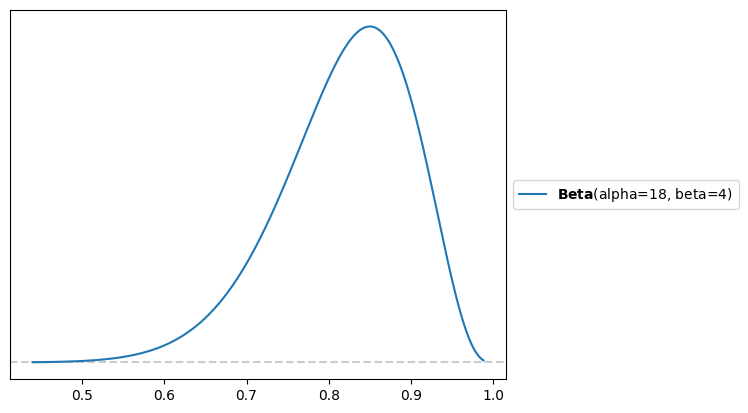

In [72]:
p_θ.plot_pdf()

## The Data

The dataset I found on Kaggle is titled [Trains and Delays Deutsche Bahn](https://www.kaggle.com/datasets/santiagoravotti/trains-and-delays-deutsche-bahn). It looks at trains covering Germany's 20 largest cities. Each record in the data is a train arriving at a certain station and all associated charactersitics. These include expected time, train model, route, platform, and delay. First, I have to read in the data and turn it into a list of yeses and nos. Luckily, there is a column called `has_delay` which indicates whether a delay occured.

In [73]:
import pandas as pd

In [75]:
df = pd.read_csv("trains.csv")
df

,date,Hbf,scheduled_time,expected_time,train_model,route,platform,real_time_due_to_delay,has_delay
0,2024-09-01,Köln Hbf,13:00,13:00,RE 8(10819),"Rommerskirchen, 13:00",3,13:00,0
1,2024-09-01,Hannover Hbf,13:00,13:00,S 2,"Nienburg(Weser), 13:00",1,13:00,0
2,2024-09-01,Münster(Westf)Hbf,13:00,13:00,RB 89(90018),"Paderborn Hbf, 13:00",3,13:00,0
3,2024-09-01,Hamburg Hbf,13:01,13:01,S 5,"Hamburg Elbgaustraße, 13:01",4Hamburg Hbf (S-Bahn),13:01,0
4,2024-09-01,Frankfurt(Main)Hbf,13:01,13:01,S 4,"Kronberg(Taunus), 13:01",101Frankfurt Hbf (tief),13:01,0
...,...,...,...,...,...,...,...,...,...
77141,2024-07-23,Bremen Hbf,09:39,09:40,RE 8(4408),"Hannover Hbf, 09:40",7,"09:40,Grund: Verspätung eines vorausfahrenden ...",1
77142,2024-07-25,Bremen Hbf,09:39,09:41,RE 8(4408),"Hannover Hbf, 09:41",7,09:41,1
77143,2024-07-21,Bremen Hbf,09:39,09:42,RE 8(4408),"Hannover Hbf, 09:42",7,09:42,1
77144,2024-07-24,Bremen Hbf,09:39,09:39,RE 8(4408),"Hannover Hbf, 10:05",6,"10:05,Grund: Technische Störung am Zug,Gleiswe...",1


In [90]:
num_on_time = len(df[df.has_delay == 0])
num_delayed = len(df[df.has_delay == 1])
total = num_on_time + num_delayed

print(f"On time: {num_on_time}, Delayed: {num_delayed}")

On time: 42892, Delayed: 34254


## The Likelihood

So we know that, 42,892 trains came on time and 34,254 were delayed. The proportion is surprising to me due to the prevalence of delays. We can now proceeed to create a likelihood ($p(y|\theta)$) based on the data using a binomial distribution.

<Axes: >

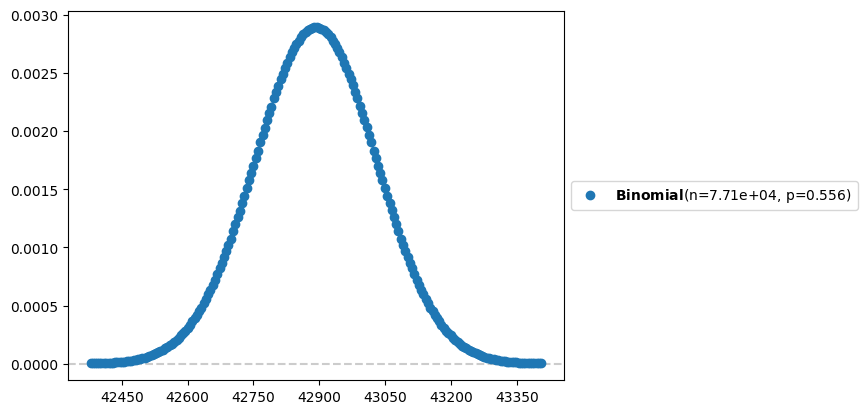

In [91]:
p_y_θ = pz.Binomial(n = total, p = num_on_time / total)
p_y_θ.plot_pdf()

## The Posterior

Given the prior and likelihood, the posterior can now be created analytically using a Beta distribution.

<Axes: >

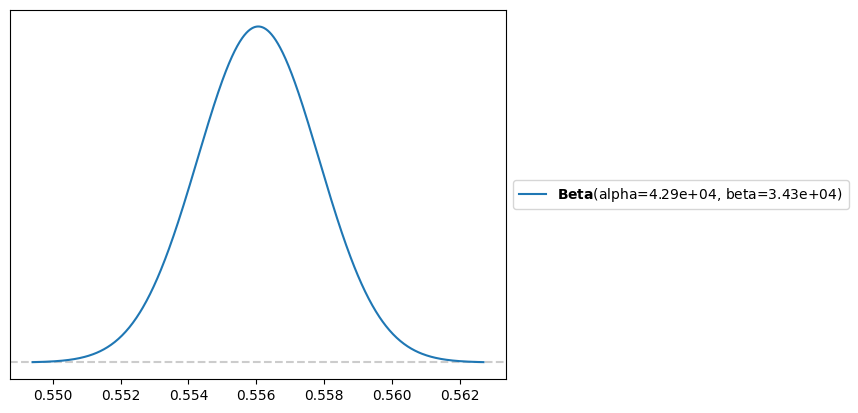

In [95]:
analytic_posterior = pz.Beta(alpha = prior_α + num_on_time, beta = prior_β + total - num_on_time)
analytic_posterior.plot_pdf()

Compared to the size of the data, my prior is extremely weak. The dataset is magnitudes larger than my prior, so the resulting posterior was basically unaffected by my prior. I decided to leave my prior as-is because my level of confidence is pretty low.

In [96]:
analytic_posterior.mean()

0.5560595065312046

This is my best guess for the percentage of trains that arrive on time in Germany.

## Probabilistic Analysis

Another way to come to a result is to use Markov Chain Monte Carlo (MCMC). I am essentially doing the same analysis, but probabalistically (the results change slightly each time this code is run). It is a powerful technique for analyzing data.

In [98]:
import pymc as pm
import numpy as np

In [99]:
data_on_time = np.repeat(1, num_on_time)
data_delayed = np.repeat(0, num_delayed)
data = np.concatenate([data_on_time, data_delayed])

In [100]:
with pm.Model() as train_delay_model:
    # Prior
    θ = pm.Beta("θ", alpha=prior_α, beta=prior_β)

    # Likelihood
    y = pm.Bernoulli("y", p=θ, observed=data)

    sample_data = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


We can visualize the results:

In [101]:
import arviz as az

<Axes: title={'center': 'θ'}>

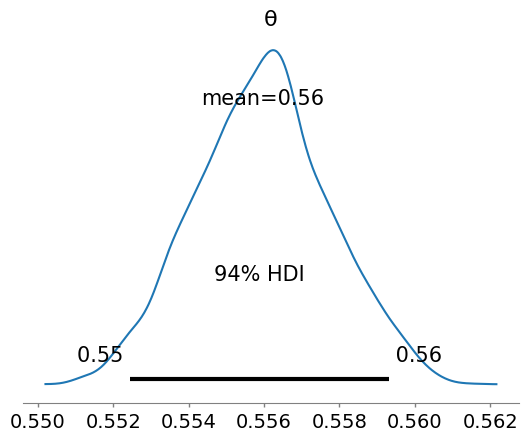

In [102]:
az.plot_posterior(sample_data)

Here is the analytic solution, for reference:

<Axes: >

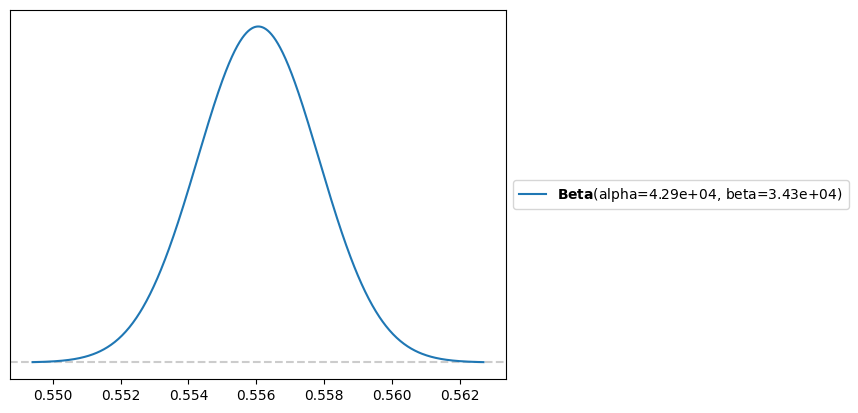

In [103]:
analytic_posterior.plot_pdf()

We can also draw samples from the analytic model, for reference:

<Axes: title={'center': 'θ'}>

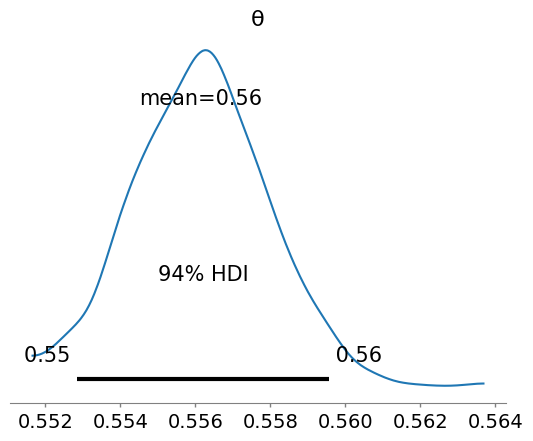

In [105]:
az.plot_posterior({"θ": analytic_posterior.rvs(1000)})

### PYMC Predictions

The PYMC model allows us to make predictions about future train delays.

In [106]:
pm.sample_posterior_predictive(sample_data, model=train_delay_model, extend_inferencedata=True)

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [108]:
stacked_samples = az.extract(sample_data, group="posterior_predictive")
stacked_samples.sel(sample=0).sel(draw=0).y.to_series().values

array([0, 1, 0, ..., 1, 1, 1])

In [109]:
stacked_samples.mean()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    y        float64 8B 0.5559

## Sources

- [The Beta-Binomial Bayesian Model](https://www.bayesrulesbook.com/chapter-3.html) – I read this article to understand the model better, but I didn't copy anything directly.
- [Beta Distribution](https://en.wikipedia.org/wiki/Beta_distribution)